In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

In [3]:
train_photo = cv2.imread('singapore/train.jpg')
train_photo = cv2.cvtColor(train_photo, cv2.COLOR_BGR2RGB)
train_photo_gray = cv2.cvtColor(train_photo, cv2.COLOR_RGB2GRAY)

query_photo = cv2.imread('singapore/query.jpg')
query_photo = cv2.cvtColor(query_photo, cv2.COLOR_BGR2RGB)
query_photo_gray = cv2.cvtColor(query_photo, cv2.COLOR_RGB2GRAY)

### Viewing the Images

Text(0.5, 0, 'Train Photo')

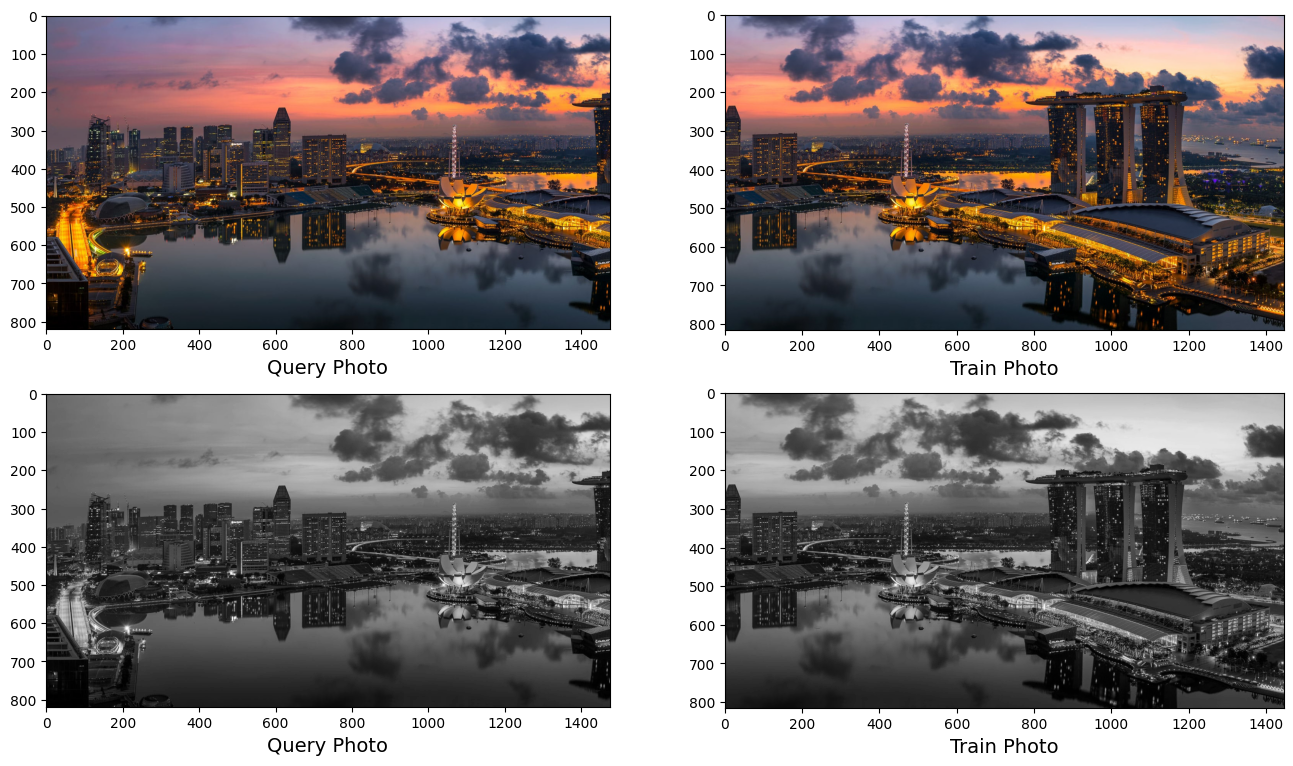

In [4]:
fig, ax = plt.subplots(2,2, constrained_layout = False, figsize=(16, 9))
ax[0,0].imshow(query_photo, cmap = 'gray')
ax[0,0].set_xlabel("Query Photo", fontsize=14)

ax[0,1].imshow(train_photo, cmap = 'gray')
ax[0,1].set_xlabel("Train Photo", fontsize=14)

ax[1,0].imshow(query_photo_gray, cmap = 'gray')
ax[1,0].set_xlabel("Query Photo", fontsize=14)

ax[1,1].imshow(train_photo_gray, cmap = 'gray')
ax[1,1].set_xlabel("Train Photo", fontsize=14)

In [5]:
def sift_detector(image):
    descriptor = cv2.SIFT_create()
    keypoints, features = descriptor.detectAndCompute(image, None)
    
    return keypoints, features

keypoints_train_image, features_train_image = sift_detector(train_photo_gray) 
keypoints_query_image, features_query_image = sift_detector(query_photo_gray)    
print(f'lenght the keypoints: {len(keypoints_train_image)}') 
print(f'descriptor shape: {features_train_image.shape}')

lenght the keypoints: 6086
descriptor shape: (6086, 128)


In [6]:
for keypoint in keypoints_query_image:
    x, y = keypoint.pt
    size = keypoint.size
    orientation = keypoint.angle
    response = keypoint.response
    octave = keypoint.octave
    class_id = keypoint.class_id

print(f'x, y: {x, y}')
print(f"size: {size}")
print(f"orientation: {orientation}")
print(f"response: {response}")
print(f"octave: {octave}")
print(f"class_id: {class_id}")


x, y: (1472.0048828125, 116.56388854980469)
size: 2.0020148754119873
orientation: 98.62557983398438
response: 0.017185334116220474
octave: 7864831
class_id: -1


In [7]:
features_query_image.shape 
len(keypoints_query_image)

4922

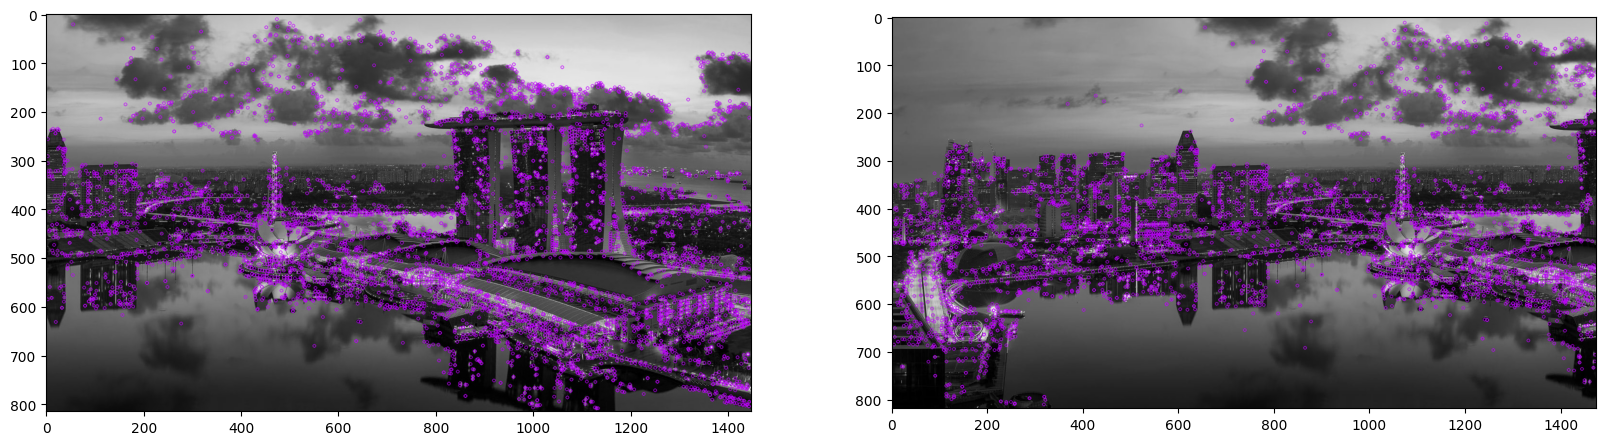

In [8]:
fig, ax = plt.subplots(1,2, figsize=(20,8), constrained_layout=False)
ax[0].imshow(cv2.drawKeypoints(train_photo_gray, keypoints_train_image, None, color = (191 , 0, 255)))

ax[1].imshow(cv2.drawKeypoints(query_photo_gray, keypoints_query_image, None, color = (191, 0, 255)))

plt.savefig('./outputs/'+ 'sift' + '_feature_image' + '.jpeg', bbox_inches='tight', dpi=300, format='jpeg')

### Matching keypoints

In [9]:
def create_match():
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    return bf

In [10]:
def keypoints_matching(features_train_image, features_query_image):
    bf = create_match()
    
    best_matches = bf.match(features_train_image, features_query_image)
    
    raw_matches = sorted(best_matches, key = lambda x: x.distance)
    print(f"raw matchines with brute force: {len(raw_matches)}")
    
    return raw_matches

drawing matches for bf


raw matchines with brute force: 2696
matches: < cv2.DMatch 0x73a5311ad830>


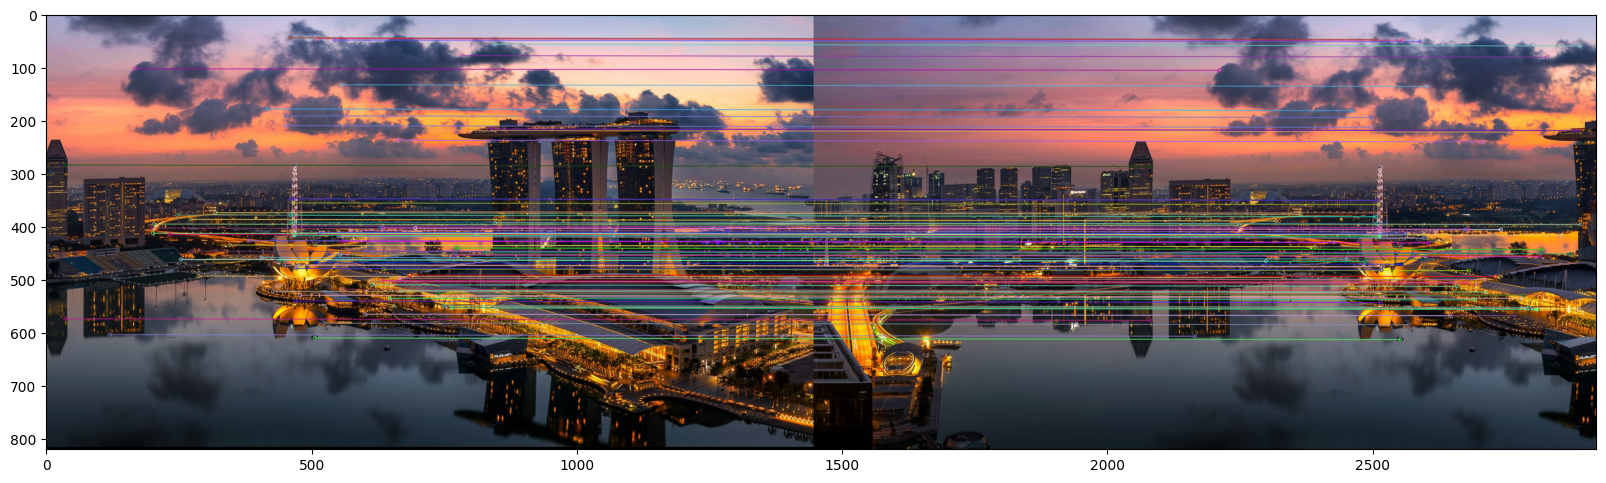

In [11]:
print(f'drawing matches for bf')
fig = plt.figure(figsize=(20, 8))
matches = keypoints_matching(features_train_image, features_query_image)
print(f'matches: {matches[0]}')
mapped_feature_image = cv2.drawMatches(train_photo, keypoints_train_image, query_photo, keypoints_query_image, matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_feature_image)

In [12]:
def homography_stitching(keypoints_train_image, keypoints_query_image, matches, reprojThresh):
    #convert to 2 numpy array of coordinates to find hommography
    keypoints_train_image = np.float32([keypoint.pt for keypoint in keypoints_train_image])
    keypoints_query_image = np.float32([keypoint.pt for keypoint in keypoints_query_image])
    
    #minimum match count for homography is 4
    if len(matches) >= 4:
        points_train = np.float32([keypoints_train_image[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_image[m.trainIdx] for m in matches])
        
        (H, status) = cv2.findHomography(points_train, points_query)